# A General Perspective on Graph Neural Networks

## General GNN Framework

Consider the following GNN layer:

$$
    h_v^{(l)} = \sigma \left( \operatorname{AGG}^{(l)} \left( \{\operatorname{MSG}^{(l)}(h_u^{(l-1)} \mid u \in N(v))\} \right) \right)
$$

1. Explain the role of `AGG` and `MSG` components.
1. Why must `AGG` be permutation invariant?
1. What issue arises in this formulation? (Hint: Consider how node $v$ incorporates information about itself.)
1. How can we modify this equation to fix the issue in (3)?
1. Modify the layer so that self-information and neighbor-information are treated differently. Provide the updated equation. (Hint: You are not limited to a single trainable weight matrix.)

## Depth of a GNN

Consider the following GNN layer:
$$
    h_v^{(l)} = \operatorname{CONCAT} \big( \operatorname{AGG} \big( \{ m_u^{(l)} \mid u \in N(v) \} \big), m_v^{(l)} \big)
$$
where $m_u^{(l)}=\operatorname{MSG}^{(l)}(h_u^{(l-1)})$ are the messages from neighbors and $m_v^{(l)}=\operatorname{MSG}^{(l)}(h_v^{(l-1)})$ is the self-message.

1. Assume that the `AGG` is the `SUM` function, and the messages $m_u^{(l)}$ and $m_v^{(l)}$ are $d$-dimensional vectors. What is the dimension of $h_v^{(l)}$?
1. Discuss potential issues or challenges this concatenation might introduce when stacking multiple GNN layers.
1. Suggest a technique to control the dimension after concatenation.
1. Now, assume that we change the layer definition so that the concatenated vector is fed to a $k$-layer multi-layer perceptron (MLP) as given in the following:
    $$
        h_v^{(l)} = \operatorname{MLP} \big( \operatorname{CONCAT} \big( \operatorname{AGG} \big( \{ m_u^{(l)} \mid u \in N(v) \} \big), m_v^{(l)} \big) \big)
    $$
    If we stack $L$ such layers, what will be the total depth of the GNN?

## Graph Convolutional Networks

Consider the layer definition of the GCN by Kipf & Welling (paper [link](https://arxiv.org/abs/1609.02907)):

$$
    h_v^{(l+1)} = \sigma\left( \sum_{u \in N(v) \cup \{v\}} \frac{1}{\sqrt{\tilde{d}_v \tilde{d}_u}} \, h_u^{(l)} W^{(l)} \right)
$$
where $\tilde{d}_v$ is the degree of node $v$ in the augmented adjacency $\tilde{A} = A + I$ after adding self-loops.

1. Compared to the simple normalization factor $\frac{1}{|N(v)|}$ we have seen in the lecture (W4, slide 17), what could be the reason to have $\frac{1}{\sqrt{\tilde{d}_v \tilde{d}_u}}$ (symmetric normalization)?

1. How does the GCN process a node's own message differently from its neighbors' messages?

1. GraphSAGE (SAmple and aggreGatE) by Hamilton et. al. (paper [link](https://arxiv.org/abs/1706.02216)) is an extension of the GCN framework. Given the pseudocode below, list three aspects of GraphSAGE that is different from the original GCN and discuss how these changes improve the method.

    ![alt text](assets/w4_graphsage.png "GraphSAGE Algorithm")

1. How does the Graph Attention Network by Veličković et. al. ([paper](https://arxiv.org/abs/1710.10903)) improve the GCN?

## Programming: Simple GNN with Torch

In this exercise, you'll implement a simple GNN with `pytorch` and test on the `Cora` dataset ([link](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html)).

The layer definition of the GNN you'll implement is given as follows:

$$
    h_v^{(l)} = \sigma \left( W_{\text{self}}^{(l)} \cdot h_v^{(l-1)} + W_{\text{neigh}}^{(l)} \cdot \operatorname{AGG}^{(l)}\left(\{h_u^{(l-1)} \mid u \in N(v)\}\right) \right)
$$

Basically, it uses two learnable weight matrices $W_{\text{self}}$ and $W_{\text{neigh}}$ that are multiplied with the messages from the node's self and aggregated messages from neighbors, respectively. Then, the resulting vectors are summed and fed to $\sigma$.

1. Complete the following code snippet given the following:
    - Use `MEAN` aggretagor for neighbor messages.
    - Use ReLU as $\sigma$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ============================================================================
# GRAPH NEURAL NETWORK (GNN) IMPLEMENTATION
# ============================================================================
# This code implements a simple Graph Neural Network that learns from graph-structured data.
# 
# EXAMPLE GRAPH:
#   Node 0 --- Node 1
#     |          |
#   Node 2 --- Node 3
# 
# In this example:
# - 4 nodes (0, 1, 2, 3)
# - Edges: (0,1), (0,2), (1,3), (2,3)
# ============================================================================


class SimpleGNNLayer(nn.Module):
    """
    A single Graph Neural Network layer that updates node features by:
    1. Aggregating information from neighboring nodes (mean aggregation)
    2. Combining own features with aggregated neighbor features
    
    INTUITION: Each node learns a new representation by looking at its 
    neighbors' features, similar to how you might update your opinion by 
    listening to your friends.
    
    EXAMPLE:
    If Node 0 is connected to Nodes 1 and 2:
    - Node 0's new features = f(Node 0's current features, average of Node 1 and Node 2's features)
    """
    
    def __init__(self, in_dim, out_dim):
        """
        Initialize the GNN layer with separate weight matrices.
        
        Args:
            in_dim: Input feature dimension (e.g., 16 features per node)
            out_dim: Output feature dimension (e.g., 32 features per node)
        
        EXAMPLE:
        If in_dim=3 and out_dim=5:
        - Each node starts with 3 features
        - After this layer, each node will have 5 features
        """
        super().__init__()
        
        # Separate linear transformations for self and neighbor features
        # This allows the model to learn different importance for:
        # - What I already know (self)
        # - What my neighbors tell me (neighbors)
        self.linear_self = nn.Linear(in_dim, out_dim, bias=True)
        self.linear_neigh = nn.Linear(in_dim, out_dim, bias=True)

    def forward(self, x, edge_index):
        """
        Forward pass: Update all node features using graph structure.
        
        Args:
            x: Node feature matrix, shape [N, in_dim]
               N = number of nodes, in_dim = features per node
               EXAMPLE: If we have 4 nodes with 3 features each:
                        x = [[0.1, 0.2, 0.3],  # Node 0
                             [0.4, 0.5, 0.6],  # Node 1
                             [0.7, 0.8, 0.9],  # Node 2
                             [1.0, 1.1, 1.2]]  # Node 3
            
            edge_index: Graph connectivity, shape [2, E]
                        E = number of edges
                        Format: [[target_nodes], [source_nodes]]
                        EXAMPLE: For edges (1→0), (2→0), (3→1), (3→2):
                                 edge_index = [[0, 0, 1, 2],  # target nodes (who receives)
                                               [1, 2, 3, 3]]  # source nodes (who sends)
        
        Returns:
            Updated node features, shape [N, out_dim]
        """
        
        # ====================================================================
        # STEP 1: Extract edge information
        # ====================================================================
        # edges j -> i (col = source who sends, row = target who receives)
        row, col = edge_index
        # EXAMPLE: If edge_index = [[0, 1], [2, 3]]
        #          row = [0, 1] (receivers)
        #          col = [2, 3] (senders)
        #          This means: Node 2 → Node 0, Node 3 → Node 1

        # ====================================================================
        # STEP 2: Gather messages from neighbors
        # ====================================================================
        # For each edge, get the source node's features
        messages = x[col]
        # EXAMPLE: If col = [1, 2, 2] and x has 4 nodes:
        #          messages = [x[1], x[2], x[2]]
        #          These are the features being "sent" along edges

        # ====================================================================
        # STEP 3: Aggregate messages by mean (average neighbor features)
        # ====================================================================
        # We want to compute the average features of neighbors for each node
        
        N = x.size(0)  # Number of nodes in the graph
        # EXAMPLE: If x.shape = [4, 16], then N = 4
        
        # Initialize aggregation buffer with zeros
        agg = torch.zeros(N, x.size(1), device=x.device)
        # EXAMPLE: If N=4 nodes with 16 features: agg.shape = [4, 16]
        
        # Sum all incoming messages for each target node
        # index_add_ accumulates values: agg[row[i]] += messages[i]
        agg.index_add_(0, row, messages)
        # EXAMPLE: If row = [0, 0, 1] and messages has 3 feature vectors:
        #          agg[0] = messages[0] + messages[1]  (Node 0 receives 2 messages)
        #          agg[1] = messages[2]                (Node 1 receives 1 message)
        # 
        # It basically does:
        # for k in range(len(index)):
        #     target[index[k]] += source[k]
        # This is done in parallel and very fast on GPU!
        
        # Count how many neighbors each node has (degree)
        deg = torch.bincount(row, minlength=N).clamp(min=1).unsqueeze(1)
        # EXAMPLE: If row = [0, 0, 1]:
        #          bincount gives [2, 1, 0, 0] (Node 0 has 2 neighbors, Node 1 has 1)
        #          clamp(min=1) gives [2, 1, 1, 1] (avoid division by zero)
        #          unsqueeze(1) reshapes to [4, 1] for broadcasting
        #          unsqueeze adds a dimension of size 1. 
        #          It changes the shape of the tensor.
        
        # Divide sum by count to get mean
        agg = agg / deg
        # EXAMPLE: If agg[0] = [2.0, 4.0] and deg[0] = 2:
        #          agg[0] = [1.0, 2.0] (mean of two neighbors)

        # ====================================================================
        # STEP 4: Combine self features and aggregated neighbor features
        # ====================================================================
        # Update rule: new_features = W_self * self_features + W_neigh * neighbor_features
        # This is like saying: "My new representation is a weighted combination of 
        # what I know and what my neighbors tell me"
        
        out = self.linear_self(x) + self.linear_neigh(agg)
        # EXAMPLE: If x[0] = [1, 2, 3] and agg[0] = [4, 5, 6]:
        #          out[0] = W_self @ [1,2,3] + W_neigh @ [4,5,6]
        #          The model learns W_self and W_neigh during training

        # ====================================================================
        # STEP 5: Return updated node features
        # ====================================================================
        return out
        # EXAMPLE OUTPUT: If input was [4, 16] and out_dim=32:
        #                 output will be [4, 32] (same number of nodes, new features)


class SimpleGNN(nn.Module):
    """
    A complete 2-layer Graph Neural Network model.
    
    ARCHITECTURE:
    Input features → GNN Layer 1 → ReLU → GNN Layer 2 → Output features
    
    INTUITION: Stacking multiple GNN layers allows each node to gather 
    information from farther away in the graph:
    - Layer 1: Each node sees its immediate neighbors
    - Layer 2: Each node sees neighbors of neighbors (2-hop neighborhood)
    
    EXAMPLE USE CASE - Node Classification:
    Input: Social network where each person has initial features
    Output: Predict categories for each person (e.g., interests, communities)
    """
    
    def __init__(self, in_dim, hidden_dim, out_dim):
        """
        Initialize the 2-layer GNN.
        
        Args:
            in_dim: Input feature dimension
            hidden_dim: Hidden layer dimension
            out_dim: Output feature dimension (e.g., number of classes)
        
        EXAMPLE:
        SimpleGNN(in_dim=10, hidden_dim=64, out_dim=7)
        - Input: 10 features per node
        - Hidden: 64 features after first layer
        - Output: 7 features (e.g., 7 class predictions)
        """
        super().__init__()
        self.layer1 = SimpleGNNLayer(in_dim, hidden_dim)
        self.layer2 = SimpleGNNLayer(hidden_dim, out_dim)

    def forward(self, data):
        """
        Forward pass through the entire GNN.
        
        Args:
            data: Graph data object containing:
                  - data.x: Node features [N, in_dim]
                  - data.edge_index: Graph structure [2, E]
        
        Returns:
            Node predictions/embeddings [N, out_dim]
        
        EXAMPLE:
        Input:  4 nodes, each with 10 features
        Output: 4 nodes, each with 7 class scores
        """
        x, edge_index = data.x, data.edge_index

        # ====================================================================
        # Apply GNN layers with ReLU non-linearity
        # ====================================================================
        
        # First GNN layer: Aggregate 1-hop neighborhood information
        x = self.layer1(x, edge_index)
        # EXAMPLE: x.shape changes from [4, 10] to [4, 64]
        
        # Non-linearity: ReLU activation introduces non-linear transformations
        # ReLU(x) = max(0, x) - sets negative values to 0
        x = F.relu(x)
        # EXAMPLE: If x[0] = [-1.0, 2.0, -0.5], then relu(x[0]) = [0.0, 2.0, 0.0]
        
        # Second GNN layer: Aggregate 2-hop neighborhood information
        x = self.layer2(x, edge_index)
        # EXAMPLE: x.shape changes from [4, 64] to [4, 7]
        # Now each node has information from its 2-hop neighborhood

        return x
        # EXAMPLE OUTPUT: If predicting node categories:
        #                 [[0.1, 0.8, 0.05, 0.02, 0.01, 0.01, 0.01],  # Node 0: likely class 1
        #                  [0.7, 0.1, 0.1, 0.05, 0.02, 0.02, 0.01],   # Node 1: likely class 0
        #                  ...]


# ============================================================================
# USAGE EXAMPLE
# ============================================================================
# 
# # Create a simple graph with 4 nodes
# x = torch.randn(4, 10)  # 4 nodes, 10 features each
# edge_index = torch.tensor([[0, 1, 2, 3],  # targets
#                            [1, 0, 3, 2]], dtype=torch.long)  # sources
# 
# # Create data object (using PyTorch Geometric format)
# from torch_geometric.data import Data
# data = Data(x=x, edge_index=edge_index)
# 
# # Initialize and run the model
# model = SimpleGNN(in_dim=10, hidden_dim=64, out_dim=7)
# output = model(data)  # Shape: [4, 7] - 7 scores for each of 4 nodes
# 
# # For node classification, apply softmax to get probabilities
# predictions = torch.softmax(output, dim=1)
# ============================================================================

Now, train your GNN using the following script.

d:\Marburg Exercises\machine-learning-with-graphs\.venv\Lib\site-packages\torch_geometric\__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not load this library: D:\Marburg Exercises\machine-learning-with-graphs\.venv\Lib\site-packages\libpyg.pyd
  import torch_geometric.typing
d:\Marburg Exercises\machine-learning-with-graphs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: Cora()
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7

Using device: cpu

Model architecture:
  Input: 1433 features per node
  Hidden: 16 features (after layer 1)
  Output: 7 class scores

Graph data:
  Nodes (papers): 2708
  Edges (citations): 10556
  Training nodes: 140
  Validation nodes: 500
  Test nodes: 1000

Starting training...

Epoch  0: Train Loss = 1.9520
Epoch  1: Train Loss = 1.7393
Epoch  2: Train Loss = 1.4500
Epoch  3: Train Loss = 1.1511
Epoch  4: Train Loss = 0.8671
Epoch  5: Train Loss = 0.6194
Epoch  6: Train Loss = 0.4216
Epoch  7: Train Loss = 0.2758
Epoch  8: Train Loss = 0.1759
Epoch  9: Train Loss = 0.1110
Epoch 10: Train Loss = 0.0696
Epoch 11: Train Loss = 0.0436
Epoch 12: Train Loss = 0.0275
Epoch 13: Train Loss = 0.0177
Epoch 14: Train Loss = 0.0117
Epoch 15: Train Loss = 0.0080
Epoch 16: Train Loss = 0.0056
Epoch 17: Train Loss = 0.0041
Epoch 18: Train Loss = 0.0030
Epoch 19

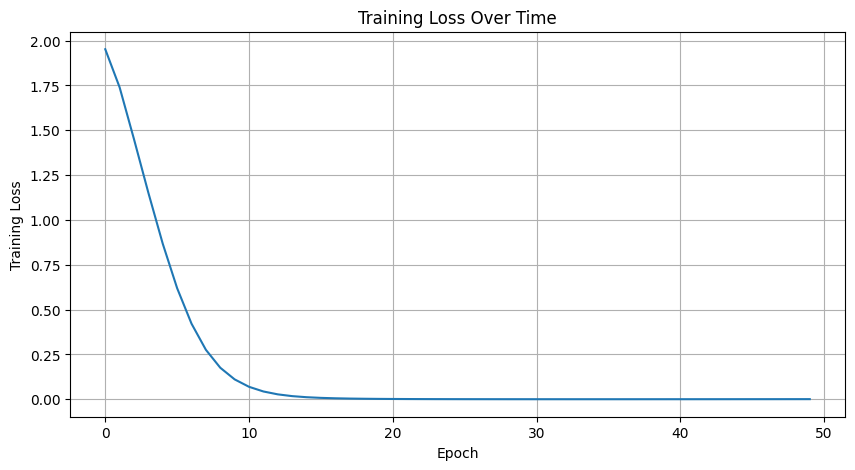

In [2]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F

# ============================================================================
# DATASET: CORA - A CITATION NETWORK
# ============================================================================
# WHAT IS CORA?
# - A dataset of scientific papers (nodes) and citations between them (edges)
# - 2,708 papers (nodes)
# - 10,556 citation links (edges)
# - Each paper has:
#   * 1,433 features (bag-of-words representation of the paper)
#   * 1 label out of 7 categories (e.g., Neural Networks, Reinforcement Learning)
#
# TASK: Given paper features and citation network, predict the research area
#       of each paper (node classification)
#
# EXAMPLE: If Paper A cites Papers B and C, and B and C are about "Neural Networks",
#          then Paper A is likely also about "Neural Networks"
# ============================================================================

# Load the Cora dataset from disk (downloads if not present)
dataset = Planetoid(root='/tmp/Cora', name='Cora')
# Planetoid is a collection of citation network datasets
# Other options: 'CiteSeer', 'PubMed'

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")  # 1 (single graph)
print(f"Number of nodes: {dataset[0].num_nodes}")  # 2,708 papers
print(f"Number of edges: {dataset[0].num_edges}")  # 10,556 citations
print(f"Number of features per node: {dataset.num_node_features}")  # 1,433
print(f"Number of classes: {dataset.num_classes}")  # 7 research areas
print()


# ============================================================================
# SETUP: MODEL, DEVICE, DATA, OPTIMIZER
# ============================================================================

# Determine if GPU is available (much faster for training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Initialize the GNN model
# Architecture: 1433 input features → 16 hidden → 7 output classes
model = SimpleGNN(
    in_dim=dataset.num_node_features,  # 1,433 (word features)
    hidden_dim=16,                      # 16 (compressed representation)
    out_dim=dataset.num_classes         # 7 (one score per class)
).to(device)

print(f"Model architecture:")
print(f"  Input: {dataset.num_node_features} features per node")
print(f"  Hidden: 16 features (after layer 1)")
print(f"  Output: {dataset.num_classes} class scores")
print()

# Get the graph data
# In Cora, there's only one big graph containing all papers
data = dataset[0].to(device)

# DATA STRUCTURE:
# data.x: Node features [2708, 1433] - features for each paper
# data.edge_index: Graph structure [2, 10556] - which papers cite which
# data.y: True labels [2708] - actual research area for each paper
# data.train_mask: Boolean mask [2708] - which nodes to use for training
# data.val_mask: Boolean mask [2708] - which nodes to use for validation
# data.test_mask: Boolean mask [2708] - which nodes to use for testing

print(f"Graph data:")
print(f"  Nodes (papers): {data.num_nodes}")
print(f"  Edges (citations): {data.num_edges}")
print(f"  Training nodes: {data.train_mask.sum().item()}")
print(f"  Validation nodes: {data.val_mask.sum().item()}")
print(f"  Test nodes: {data.test_mask.sum().item()}")
print()

# IMPORTANT: Semi-supervised learning setup
# We only have labels for a subset of nodes (140 for training)
# But the GNN can use the entire graph structure and all node features
# This is the power of GNNs: they leverage the graph structure!

# Initialize optimizer
# Adam: adaptive learning rate optimizer
# lr=0.01: learning rate (how big each update step is)
# weight_decay=5e-4: L2 regularization to prevent overfitting
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.01,           # EXAMPLE: If gradient is 2.0, update = -0.01 * 2.0 = -0.02
    weight_decay=5e-4  # Penalizes large weights to keep model simple
)


# ============================================================================
# TRAINING LOOP: TEACH THE MODEL TO CLASSIFY PAPERS
# ============================================================================
# TRAINING PROCESS:
# 1. Forward pass: Make predictions for all nodes
# 2. Compute loss: How wrong are predictions on training nodes?
# 3. Backward pass: Calculate gradients (how to improve)
# 4. Update weights: Adjust model parameters to reduce loss
# ============================================================================

train_losses = []  # Store loss values for plotting later

# Set model to training mode (enables dropout, batch norm, etc. if present)
model.train()

print("Starting training...\n")

# Train for 50 epochs (full passes through the data)
for epoch in range(50):
    
    # ========================================================================
    # STEP 1: ZERO GRADIENTS
    # ========================================================================
    # Clear gradients from previous iteration
    # Without this, gradients would accumulate across iterations (wrong!)
    optimizer.zero_grad()
    # ANALOGY: Erasing the blackboard before solving a new problem
    
    # ========================================================================
    # STEP 2: FORWARD PASS
    # ========================================================================
    # Get predictions for ALL nodes in the graph
    out = model(data)
    # out.shape = [2708, 7] - 7 class scores for each of 2708 papers
    #
    # EXAMPLE OUTPUT for one node:
    # out[0] = [0.2, 0.5, 0.1, 0.05, 0.05, 0.05, 0.05]
    #          ↑ scores for each of 7 classes
    # Higher score = model thinks this class is more likely
    
    # ========================================================================
    # STEP 3: COMPUTE LOSS (only on training nodes!)
    # ========================================================================
    # Cross-entropy loss: measures how different predictions are from true labels
    # We ONLY compute loss on nodes in the training set (data.train_mask)
    loss = F.cross_entropy(
        out[data.train_mask],    # Predictions for training nodes only [140, 7]
        data.y[data.train_mask]  # True labels for training nodes only [140]
    )
    # EXAMPLE:
    # If true label is class 1, and predictions are [0.1, 0.8, 0.05, ...]:
    #   Good! High score for correct class → low loss
    # If predictions are [0.5, 0.2, 0.1, ...]:
    #   Bad! Low score for correct class → high loss
    #
    # Cross-entropy formula: -log(probability of correct class)
    # So we want to maximize the probability of the correct class
    
    # ========================================================================
    # STEP 4: BACKWARD PASS
    # ========================================================================
    # Compute gradients: how should each weight change to reduce loss?
    loss.backward()
    # This calculates ∂loss/∂weight for every parameter in the model
    # EXAMPLE: If increasing weight W by 0.01 would decrease loss by 0.1,
    #          then gradient is -10.0 (negative because loss goes down)
    
    # ========================================================================
    # STEP 5: UPDATE WEIGHTS
    # ========================================================================
    # Adjust model parameters using computed gradients
    optimizer.step()
    # For each weight: weight_new = weight_old - learning_rate * gradient
    # EXAMPLE: weight = 0.5, gradient = -10.0, lr = 0.01
    #          weight_new = 0.5 - 0.01 * (-10.0) = 0.5 + 0.1 = 0.6
    
    # Record loss for this epoch
    train_losses.append(loss.item())
    print(f"Epoch {epoch:2d}: Train Loss = {loss.item():.4f}")
    
    # WHAT'S HAPPENING EACH EPOCH:
    # - Model makes predictions using current weights
    # - Compares predictions to true labels (for training nodes only)
    # - Adjusts weights to make better predictions
    # - Over time, loss should decrease (model is learning!)

print("\nTraining complete!\n")


# ============================================================================
# EVALUATION: TEST THE MODEL ON UNSEEN DATA
# ============================================================================
# IMPORTANT: We test on nodes the model has NEVER seen labels for during training
# This tells us if the model learned general patterns (good) or just
# memorized the training data (bad, called overfitting)
# ============================================================================

# Set model to evaluation mode (disables dropout, etc.)
model.eval()
# In eval mode: model behaves deterministically (no randomness)

# Get predictions for all nodes
# We don't need gradients for evaluation, so we can skip that computation
with torch.no_grad():  # Saves memory and speeds up computation
    out = model(data)
    # out.shape = [2708, 7] - scores for all papers

# ========================================================================
# CONVERT SCORES TO PREDICTED CLASSES
# ========================================================================
# For each node, pick the class with the highest score
pred = out.argmax(dim=1)
# argmax finds the index of the maximum value
# EXAMPLE: out[0] = [0.1, 0.8, 0.2, 0.05, 0.01, 0.03, 0.01]
#          pred[0] = 1 (index of max value 0.8)
# pred.shape = [2708] - one predicted class per paper

# ========================================================================
# CALCULATE ACCURACY ON TEST SET
# ========================================================================
# Compare predictions to true labels (only for test nodes)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
# EXAMPLE: If 800 out of 1000 test predictions are correct:
#          correct = 800

# Calculate accuracy as a percentage
acc = int(correct) / int(data.test_mask.sum())
# EXAMPLE: 800 correct / 1000 test nodes = 0.80 = 80% accuracy

print(f"Test Accuracy: {acc:.4f}")
print(f"Correct predictions: {int(correct)}/{int(data.test_mask.sum())}")
print()

# ========================================================================
# INTERPRETING RESULTS
# ========================================================================
# WHAT IS GOOD ACCURACY?
# - Random guessing: 1/7 ≈ 14.3% (7 classes)
# - Good GNN on Cora: 70-85%
# - State-of-the-art: 85-90%
#
# WHY DOES THIS WORK?
# The GNN learns that papers citing similar papers are likely in the same
# research area. By aggregating information from neighbors (cited papers),
# each paper's representation becomes more informative.
#
# EXAMPLE:
# - Paper A (unlabeled) cites Papers B, C, D
# - Papers B, C, D are all labeled "Neural Networks"
# - GNN learns: Paper A is probably also about "Neural Networks"
# ========================================================================

# Optional: Visualize training progress
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

# Training loss should generally decrease over time
# If it increases or plateaus early, might need to:
# - Adjust learning rate
# - Add more layers
# - Increase hidden dimension
# - Train for more epochs

2. Now, modify the `SimpleGNN` class so that it takes the number of layers as input.

3. Now, train two GNNs, one with 2 layers and another with 16. Then, compare the Mean Average Distance (MAD) of the embeddings learned by the models using the given function.

    - Mean Average Distance (MAD): Average pairwise Euclidean distance between node embeddings.

In [3]:
class SimpleGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2):
        super().__init__()
        layers = []
        # dims: [in_dim, hidden_dim, ..., hidden_dim, out_dim]
        dims = [in_dim] + [hidden_dim] * (num_layers - 1) + [out_dim]
        for i in range(len(dims) - 1):
            layers.append(SimpleGNNLayer(dims[i], dims[i + 1]))
        
        self.layers = nn.ModuleList(layers)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)

        if i != len(self.layers) - 1:
            # last layer -> no ReLU
            x = F.relu(x)
        
        return x

In [4]:
def get_mad(embeddings):

    # embeddings: [N, d]  (N nodes, d-dimensional embeddings)
    N = embeddings.size(0)

    # Normalize embeddings
    embeddings = F.normalize(embeddings, dim=1)

    # Compute all pairwise Euclidean distances → shape [N, N]
    dist_matrix = torch.cdist(embeddings, embeddings, p=2)

    # Average the distances over all distinct pairs
    mad_val = dist_matrix.sum() / (N * (N - 1))

    return mad_val.item()


In [10]:
from torch_geometric.datasets import Planetoid

# load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# model, data, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)

for L in [2, 32]:
    print(f"\nTraining GNN with {L} layers:")
    model = SimpleGNN(in_dim=dataset.num_node_features, hidden_dim=16, out_dim=dataset.num_classes, num_layers=L).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    
    # training loop
    train_losses = []
    model.train()
    for epoch in range(50):
    
        optimizer.zero_grad()
        out = model(data)
    
        # training loss
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}")

    # final eval
    model.eval()

    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())

    print(f"Test Accuracy: {acc:.4f}")
    print(f"MAD of final embeddings: {get_mad(model(data)):.4f}")


Training GNN with 2 layers:
Test Accuracy: 0.7780
MAD of final embeddings: 1.3204

Training GNN with 32 layers:
Test Accuracy: 0.0640
MAD of final embeddings: 0.0001


4. Interpret the accuracy and MAD values of models with 2 and 16 layers. 